In [2]:
import math
import numpy as np
import paddle
import sys
sys.path.append("../")
from paddle_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from paddle_harmonics.legendre import legpoly, clm
from paddle_harmonics import RealSHT, InverseRealSHT

import matplotlib.pyplot as plt

from plotting import plot_sphere

In [3]:
nlat = 32
nlon = 2*nlat
grid = "legendre-gauss"

# for quadrature and plotting
if grid == "legendre-gauss":
    lmax = mmax = nlat
    xq, wq = legendre_gauss_weights(nlat)
elif grid =="equiangular":
    lmax = mmax = nlat//2-1
    xq, wq = clenshaw_curtiss_weights(nlat)

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

lat = np.arccos(xq)
omega = math.pi * paddle.to_tensor(wq).astype("float32") / nlat
omega = omega.reshape([-1, 1]).tile([1, nlon])

omega.sum()

W1106 14:36:02.006148 21003 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.3, Runtime API Version: 12.4
W1106 14:36:02.016603 21003 gpu_resources.cc:164] device: 0, cuDNN Version: 9.4.


Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       12.56637096)

In [5]:
# forming the Vandermonde matrix
nmodes = int(lmax * (lmax+1) / 2)
e = paddle.zeros([nmodes, lmax, mmax], dtype=paddle.complex64)

midx = lambda l,m : l*(l+1)//2 + m

for l in range(lmax):
    for m in range(l+1):
        e[midx(l,m), l, m] = 1.0

vdm = isht(e) # nmodes x nlat x nlon

let us visualize the some entries in the Vandermonde matrix. In principle, it should contain the Spherical Harmonics in ascending order:

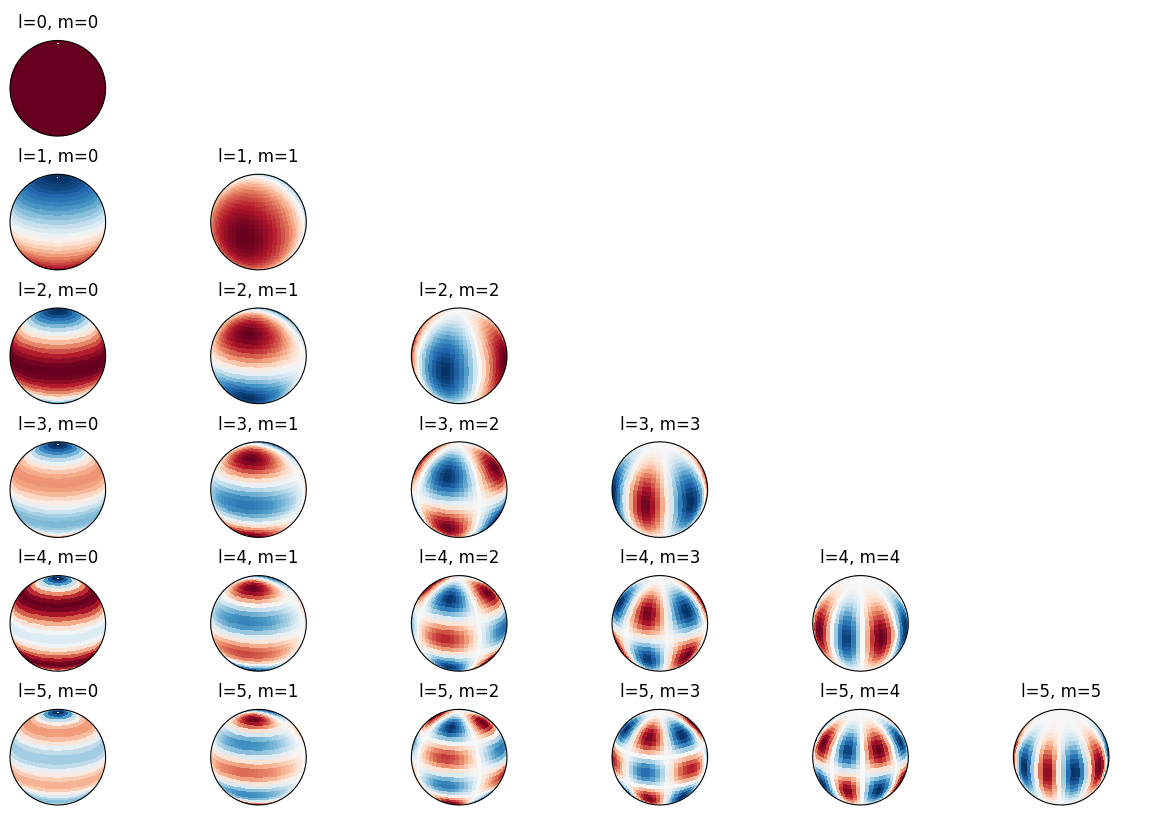

In [6]:
plt_lmax = 6

fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(plt_lmax, plt_lmax)

for l in range(plt_lmax):
    for m in range(l+1):
        plot_sphere(vdm[midx(l,m)], fig=subfigs[l, m], title=f"l={l}, m={m}", lat=(lat - np.pi/2))

now, let us compute the gramian matrix $S^T \mathop{\mathrm{diag}}(\omega) S$:

In [7]:
gramian = paddle.einsum("iqr,jqr,qr->ij", vdm, vdm, omega)

In [8]:
# plt.pcolormesh(xlg, np.arange(0, nmodes), , cmap="plasma")
# plt.xlabel("x")
# plt.ylabel("l,m mode")
# plt.colorbar()

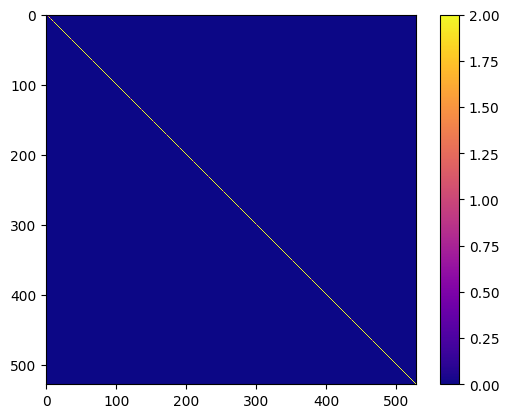

In [9]:
plt.imshow(gramian, interpolation="nearest", cmap="plasma")
plt.colorbar()

In [11]:
print(paddle.max(gramian))
print(paddle.argmax(gramian))
print(paddle.min(gramian))
print(paddle.argmin(gramian))

Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       2.00000143)
Tensor(shape=[], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       89401)
Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       -0.00000173)
Tensor(shape=[], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       229615)


In [12]:
np.linalg.cond(gramian)

2.0000105

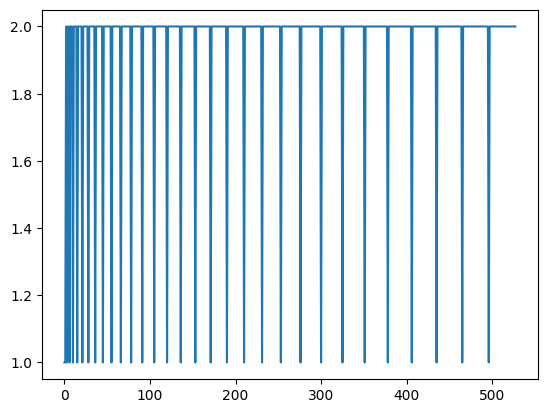

In [13]:
plt.plot(np.diag(gramian))

In [15]:
# forming the Vandermonde matrix
nmodes = int(lmax * (lmax+1) / 2)


e = paddle.zeros([lmax, mmax, lmax, mmax], dtype=paddle.complex64)
for l in range(lmax):
    for m in range(l+1):
        e[l, m, l, m] = 1.0

Sinv = isht(e).astype("complex64") # l x m x nlat x nlon

e = paddle.zeros([nlat, nlon, nlat, nlon], dtype=paddle.float32)
for lat in range(nlat):
    for lon in range(nlon):
        e[lat, lon, lat, lon] = 1.0

S = sht(e) # nlat x nlon x l x m

In [16]:
out = paddle.einsum("lmop,lmqr->lopqr", Sinv, Sinv.conj())

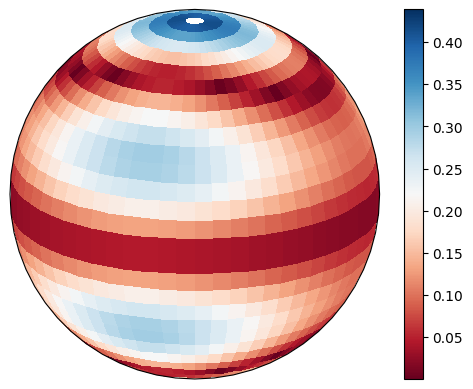

In [17]:
plot_sphere(out[3, 29, 16].abs(), colorbar=True)

In [18]:
SS = paddle.einsum("lmqr, oplm->qrop", Sinv, S)

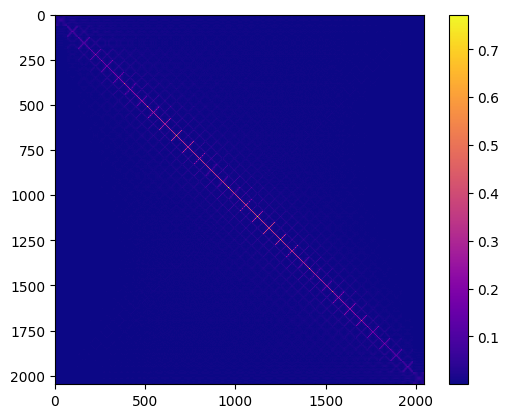

In [19]:
plt.imshow(SS.reshape(nlat*nlon, nlat*nlon).abs(), interpolation="nearest", cmap="plasma")
plt.colorbar()


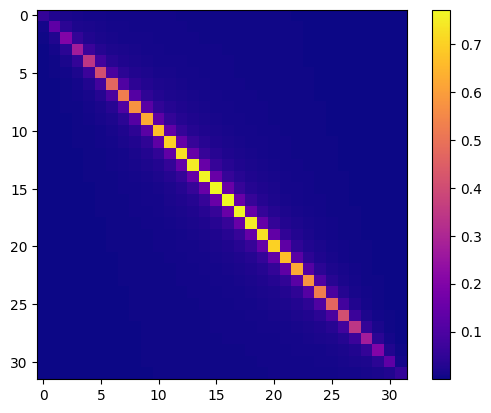

In [20]:
plt.imshow(SS[:,0,:,0].abs(), interpolation="nearest", cmap="plasma")
plt.colorbar()

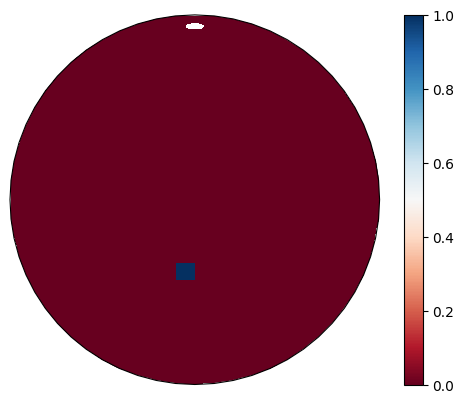

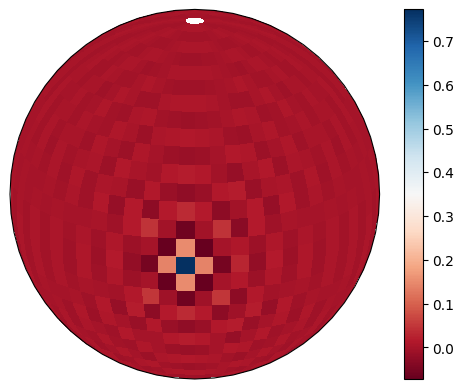

In [21]:
field = paddle.zeros([nlat, nlon])
field[16,3] = 1.0

plot_sphere(field, colorbar=True)
plot_sphere(isht(sht(field)), colorbar=True)